In [1]:
import importlib
import pydicom as dicom

import data
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import cv2
importlib.reload(data)

<module 'data' from '/Users/tyler1/cmsc472/cmsc472_medicaldiagnosis/data.py'>

In [2]:
all_data = data.load_datasets()

train_set = all_data['combined']['train']
val_set = all_data['combined']['val']

In [3]:
batch_size = 32
learning_rate = 0.0001
epochs = 500

In [4]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [5]:
class MultiClassClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(-1, 64 * 32 * 32)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [6]:
class MultiClassNet(nn.Module):

    def __init__(self, num_classes):
        super(MultiClassNet, self).__init__()
        self.procedure = nn.Sequential(
            nn.Linear(256 * 256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 256 * 256)
        return self.procedure(x)

In [12]:
num_classes = len(all_data.keys()) - 1
model = MultiClassNet(num_classes)
optim = torch.optim.SGD(model.parameters(), lr = learning_rate) 
loss_function = nn.CrossEntropyLoss()

In [13]:
train_set.images.mean()

tensor(144.8444)

In [14]:
train_loss_epochs = []
val_loss_epochs = []
train_accs_epochs = []
val_accs_epochs = []

pixel_means = train_set.images.mean(dim=0, keepdim=True)
pixel_stds = train_set.images.std(dim=0, keepdim=True, unbiased=False)


for epoch in range(epochs):

    #Training phase
    model.train()  #Setting the model to train phase
    train_loss = []
    val_loss = []

    train_accs = []
    val_accs = []

    for idx, batch in enumerate(train_dataloader):

        x = batch[0]
        x = (x-pixel_means)/pixel_stds
        x = x.unsqueeze(1)
        y = batch[1].to(torch.float32)

        optim.zero_grad()
        out = model(x)
        loss = loss_function(out, y)
        loss.backward()
        optim.step()

        
        y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)

        correct = (y_pred == y).sum().item() / num_classes
        train_acc = correct / y.size(0)



        #train_acc = torch.sum(torch.square(torch.sub(y, y_pred))).item() / (y.size(dim=0))
        #train_acc = (torch.squeeze(y_pred).eq(y)).sum().item() / y.size(dim=0)
        
        train_accs.append(train_acc)
        train_loss.append(loss.item())


    #Validation phase
    model.eval()  #Setting the model to eval mode, hence making it deterministic.
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():   #Does not calulate the graidents, as in val phase its not needed. Saves on memory.
            x = batch[0]
            x = (x-pixel_means)/pixel_stds
            x = x.unsqueeze(1)
            y = batch[1].to(torch.float32)
            out = model.forward(x)
            loss = loss_function(out, y)
            
            y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)
            
            correct = (y_pred == y).sum().item() / num_classes
            val_acc = correct / y.size(0)
            
            val_loss.append(loss.item())
            val_accs.append(val_acc)
    train_loss_epochs.append(np.mean(train_loss))
    val_loss_epochs.append(np.mean(val_loss))
    train_accs_epochs.append(np.mean(train_accs))
    val_accs_epochs.append(np.mean(val_accs))
    if epoch%1==0:
        print("Epoch : {}, Train loss: {:.5f} , Train Acc: {:.4f}, Val loss: {:.5f}, Val acc: {:.4f}".format(epoch, np.mean(train_loss), np.mean(train_acc), np.mean(val_loss), np.mean(val_acc)))
        
        

Epoch : 0, Train loss: 1.03137 , Train Acc: 0.7778, Val loss: 0.96851, Val acc: 1.0000
Epoch : 1, Train loss: 0.98110 , Train Acc: 0.7778, Val loss: 0.92294, Val acc: 1.0000
Epoch : 2, Train loss: 0.96259 , Train Acc: 1.0000, Val loss: 0.89617, Val acc: 1.0000
Epoch : 3, Train loss: 0.93649 , Train Acc: 0.7778, Val loss: 0.87630, Val acc: 1.0000
Epoch : 4, Train loss: 0.91294 , Train Acc: 1.0000, Val loss: 0.86030, Val acc: 1.0000
Epoch : 5, Train loss: 0.91758 , Train Acc: 1.0000, Val loss: 0.84888, Val acc: 1.0000
Epoch : 6, Train loss: 0.90131 , Train Acc: 1.0000, Val loss: 0.83941, Val acc: 1.0000
Epoch : 7, Train loss: 0.88903 , Train Acc: 1.0000, Val loss: 0.83147, Val acc: 1.0000
Epoch : 8, Train loss: 0.88797 , Train Acc: 0.7778, Val loss: 0.82503, Val acc: 1.0000
Epoch : 9, Train loss: 0.89839 , Train Acc: 0.5556, Val loss: 0.81982, Val acc: 1.0000
Epoch : 10, Train loss: 0.88946 , Train Acc: 0.7778, Val loss: 0.81504, Val acc: 1.0000
Epoch : 11, Train loss: 0.88393 , Train Ac

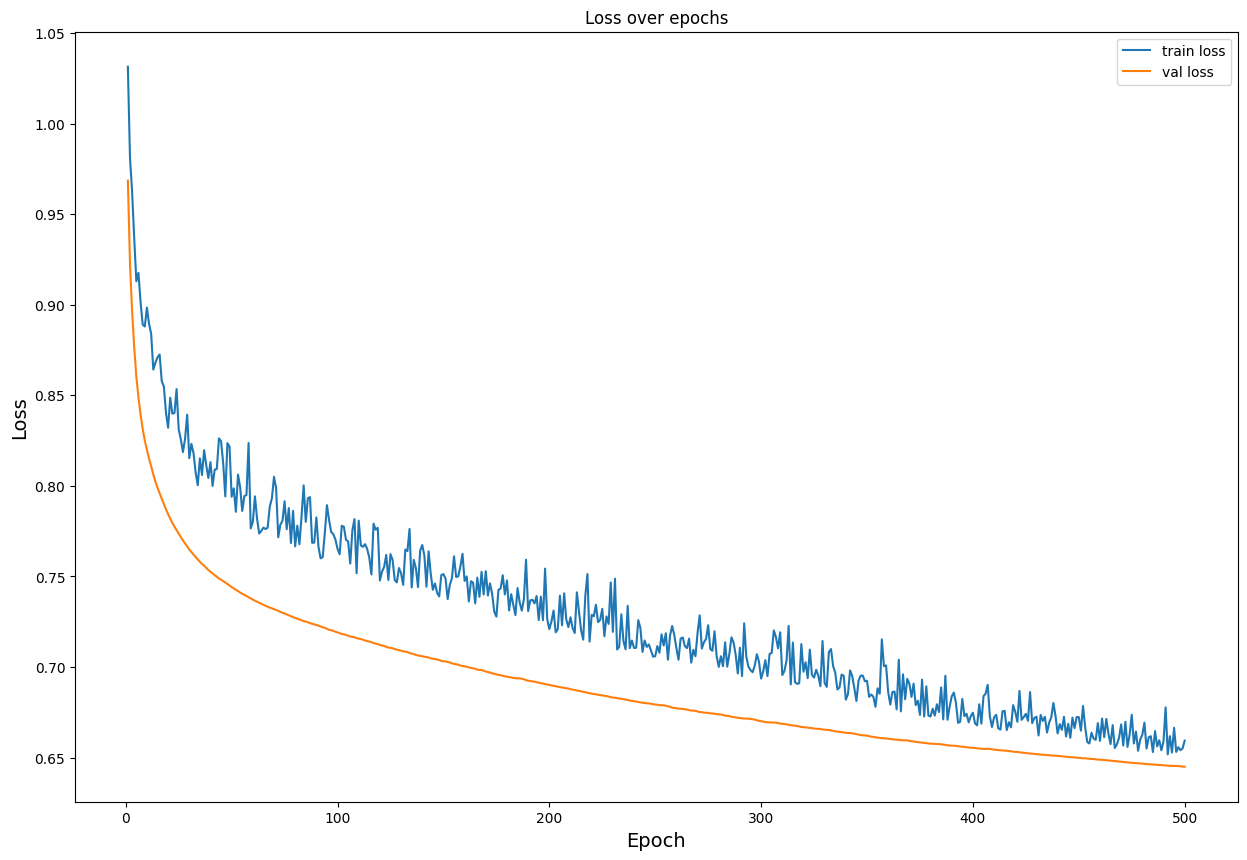

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, epochs+1), train_loss_epochs, label='train loss')
plt.plot(range(1, epochs+1), val_loss_epochs, label='val loss')
plt.xlabel("Epoch", size=14)
plt.ylabel("Loss", size=14)
plt.title("Loss over epochs")
plt.legend()
plt.show()